**社群媒體分析讀書會 hw3 第四組** 

# Week10

## 1. 載入套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# 設定中文字體
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

我們組使用東森新聞網 財經、健康、政治、體育 這四個主題的新聞來做主題分析

In [4]:
data = pd.read_csv("raw_data/東森新聞.csv")  # 匯資料
data.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,慢活安平古城 最美富人灣凌空景觀宅、訂金到交屋自備78萬起｜東森新聞,https://news.ebc.net.tw/news/article/365123,2023-05-05 14:00:00,財經,台南安平區除有歷史悠久的古蹟外，開發近20年的「五期重劃區」兼具生活機能及「慢活」悠閒步調，...,EBC
1,2,巴菲特讚台積電了不起 但投資日本比台灣自在｜東森新聞,https://news.ebc.net.tw/news/article/365550,2023-05-08 11:30:00,財經,美國「股神」巴菲特（WarrenBuffet）今天盛讚台積電是「了不起的公司」，但承認旗下波...,EBC
2,3,期交所+金融機構送愛 捐贈金額7500萬創高｜東森新聞,https://news.ebc.net.tw/news/article/365827,2023-05-10 17:31:00,財經,"為了幫助弱勢族群，期交所攜手金融機構辦理食物銀行，捐贈食物和生活用品，今年總捐贈金額更達7,...",EBC


In [5]:
# 移除網址格式
# 只留下中文字
data["artContent"] = data["artContent"].str.replace("(http|https)://.*", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("(http|https)://.*", "", regex=True)
data["artContent"] = data["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
data['content'] = data['artContent']


data = data.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
data.head(3)

,content,artUrl,artCatagory,artDate
0,台南安平區除有歷史悠久的古蹟外開發近年的五期重劃區兼具生活機能及慢活悠閒步調是許多在地人心之...,https://news.ebc.net.tw/news/article/365123,財經,2023-05-05 14:00:00
1,美國股神巴菲特今天盛讚台積電是了不起的公司但承認旗下波克夏海瑟威公司把資金配置在日本比配置在...,https://news.ebc.net.tw/news/article/365550,財經,2023-05-08 11:30:00
2,為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食物和生活用品今年總捐贈金額更達萬元是歷年...,https://news.ebc.net.tw/news/article/365827,財經,2023-05-10 17:31:00


In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

data["words"] = data["content"].apply(getToken)
data.head()

Building prefix dict from /Users/zhuangjiaqi/Desktop/SA/SMA_2024S-main/第4組_HW3/dict/dict.txt.big ...
2024-05-06 23:47:46,950 : DEBUG : Building prefix dict from /Users/zhuangjiaqi/Desktop/SA/SMA_2024S-main/第4組_HW3/dict/dict.txt.big ...
Dumping model to file cache /var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/jieba.u80b16e3e09d5f682404cf1b8686fa656.cache
2024-05-06 23:47:47,368 : DEBUG : Dumping model to file cache /var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/jieba.u80b16e3e09d5f682404cf1b8686fa656.cache
Loading model cost 0.457 seconds.
2024-05-06 23:47:47,408 : DEBUG : Loading model cost 0.457 seconds.
Prefix dict has been built successfully.
2024-05-06 23:47:47,409 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,台南安平區除有歷史悠久的古蹟外開發近年的五期重劃區兼具生活機能及慢活悠閒步調是許多在地人心之...,https://news.ebc.net.tw/news/article/365123,財經,2023-05-05 14:00:00,"[台南, 安平, 區除, 歷史悠久, 古蹟, 開發, 近年, 五期, 重劃, 兼具, 生活,..."
1,美國股神巴菲特今天盛讚台積電是了不起的公司但承認旗下波克夏海瑟威公司把資金配置在日本比配置在...,https://news.ebc.net.tw/news/article/365550,財經,2023-05-08 11:30:00,"[美國, 股神, 巴菲特, 今天, 盛讚, 台積, 電是, 了不起, 公司, 承認, 旗下,..."
2,為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食物和生活用品今年總捐贈金額更達萬元是歷年...,https://news.ebc.net.tw/news/article/365827,財經,2023-05-10 17:31:00,"[幫助, 弱勢, 族群, 期交所, 攜手, 金融機構, 辦理, 食物, 銀行, 捐贈, 食物..."
3,今天舉辦年度開發者大會發表款硬體新產品包括中階手機折疊手機及平板電腦並宣布旗下生成式人工智慧...,https://news.ebc.net.tw/news/article/365885,財經,2023-05-11 10:01:00,"[今天, 舉辦, 年度, 開發者, 大會, 發表, 硬體, 產品, 包括, 中階, 手機, ..."
4,日前一輛新車因停車格塌陷而爆出新竹天坑事件以及快速道路死亡車禍引起汽車險業者高度關注雖然兩起...,https://news.ebc.net.tw/news/article/366027,財經,2023-05-12 09:21:00,"[日前, 一輛, 新車, 停車, 塌陷, 爆出, 新竹, 天坑, 事件, 快速道路, 死亡,..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [7]:
data['artCatagory'].unique()

array(['財經', '健康', '政治', '體育'], dtype=object)

In [8]:
# 定義主題(財經)
finance_cnt = data.loc[data['artCatagory'] == '財經',:]['words'].explode().value_counts().head(100)
finance_cnt.index

Index(['公司', '台灣', '表示', '員工', '今年', '市場', '投資', '美國', '台積電', '萬元', '超過', '已經',
       '現在', '日本', '指出', '目前', '民眾', '今天', '億元', '持續', '去年', '指數', '股價', '晶片',
       '影響', '日圓', '經濟', '科技', '台積', '裁員', '報導', '未來', '美元', '利率', '中國', '全球',
       '台股', '認為', '集團', '積電', '平均', '上漲', '董事長', '成長', '產業', '台幣', '投資人',
       '仁勳', '增加', '半導體', '輝達', '金額', '股票', '漲幅', '最高', '價格', '問題', '需求', '薪資',
       '進行', '宣布', '調整', '時間', '網友', '企業', '預期', '蘋果', '銀行', '來到', '工作', '過去',
       '預計', '使用', '熊本', '執行長', '一度', '房屋', '億美元', '主要', '相關', '表現', '政府',
       '今日', '比較', '包括', '真的', '出現', '基金', '覺得', '升息', '發展', '技術', '機會', '以上',
       '成本', '最新', '需要', '大陸', '部分', '最大'],
      dtype='object')

In [9]:
# 定義主題(健康)
health_cnt = data.loc[data['artCatagory'] == '健康',:]['words'].explode().value_counts().head(200)
pprint(" ".join(health_cnt.index))

('醫師 症狀 發現 表示 治療 出現 導致 患者 造成 健康 感染 指出 建議 問題 容易 檢查 疾病 身體 提醒 醫院 增加 研究 風險 影響 嚴重 '
 '食物 民眾 使用 發生 就醫 避免 藥物 病毒 台灣 需要 原因 許多 時間 一名 女性 癌症 已經 運動 男性 產生 進行 以上 手術 無法 引起 '
 '發炎 飲食 超過 睡眠 罹患 分享 常見 流感 包括 情況 細菌 攝取 減少 醫生 狀況 比較 長期 血管 透過 病患 持續 注意 目前 通常 疫苗 '
 '改善 心臟 疼痛 皮膚 壓力 生活 糖尿病 降低 對此 是否 功能 病人 像是 授權 正常 脂肪 方式 疫情 慢性 預防 主要 死亡 最後 一定 男子 '
 '一種 認為 習慣 孩子 特別 重要 肺炎 補充 一些 提到 腫瘤 診斷 引發 說明 相關 咳嗽 族群 選擇 食品 明顯 每天 小時 肌肉 營養師 應該 '
 '個案 異常 覺得 工作 來源 接受 尤其 報導 控制 呼吸道 效果 幫助 真的 腎臟 腸胃 接種 轉載 肝臟 危險 診所 感到 醫療 血液 顯示 女子 '
 '解釋 突然 感冒 機率 熱量 相當 發燒 代謝 知道 含有 分鐘 刺激 環境 食用 透露 接觸 人體 網友 急診 臉書 心血管 之後 案例 大量 維持 '
 '呼籲 感覺 現在 有效 水果 專家 一直 乳癌 確診 急性 最近 疾管署 黴漿 新冠 過去 情緒 服用 細胞 發文 神經 眼睛 血糖 重症 下降 文章')


In [10]:
# 定義主題(政治)
politics_cnt = data.loc[data['artCatagory'] == '政治',:]['words'].explode().value_counts().head(200)
pprint(" ".join(politics_cnt.index))

('總統 國民黨 立委 民進黨 柯文 侯友宜 台灣 民眾 參選人 市長 表示 賴清德 候選人 支持 主席 現在 選舉 民調 希望 郭台銘 韓國 已經 議員 '
 '問題 萬安 今天 政治 大選 強調 認為 台北 政府 趙少康 應該 一定 最後 藍營 侯友 政黨 媒體 院長 未來 國家 真的 當選 中國 台北市 指出 '
 '知道 新北 合作 選情 時間 中華民國 進行 參選 藍白合 立法院 地方 選戰 報導 覺得 發言人 過去 能夠 面對 朱立倫 兩岸 對此 爭議 支持者 '
 '相關 綠營 回應 一起 分區 針對 是否 事情 質疑 重要 藍白 政策 投票 提出 目前 美國 徐巧 競選 持續 接受 今日 外界 看到 這是 宣布 '
 '議題 決定 英文 討論 社會 藍綠 所有 清楚 調查 代表 清德 國會 一下 選民 擔任 人選 團結 活動 市府 執政 副手 現場 民主 記者 選票 '
 '臉書 蕭美琴 這次 黨內 需要 和平 當時 記者會 出席 繼續 即時 雙方 努力 提到 選區 總統大選 要求 安全 比較 方式 包括 似乎 傳出 馬英九 '
 '公布 處理 之後 事件 公開 陣營 部分 黃國 成為 造勢 影響 高雄 說明 發生 吳欣盈 關係 力量 整合 關注 過程 提名 道歉 發文 完全 中央 '
 '不斷 一次 盧秀燕 機會 透過 團隊 共識 相信 協商 共同 行程 有人 立法 無法 高虹安 倒數 下午 主委 工作 黨團 了解 年輕人 引發 一直 '
 '特別 大陸 直接 最大 創辦人 國際')


In [11]:
# 定義主題(體育)
exercise_cnt = data.loc[data['artCatagory'] == '體育',:]['words'].explode().value_counts().head(200)
pprint(" ".join(exercise_cnt.index))

('亞運 選手 台灣 中華隊 比賽 大谷 金牌 拿下 大運 今天 球員 表示 日本 最後 杭州 聯盟 球迷 賽事 中國 奧運 球隊 今年 教練 朋友 表現 '
 '決賽 翔平 成績 中華 投手 已經 希望 對手 這次 追蹤 最終 快來 當個 項目 美國 球團 銅牌 參加 男子 覺得 擊敗 道奇 棒球 公尺 今日 '
 '進行 女子 目前 晉級 世界 國手 成都 巨蛋 好手 羽球 機會 公斤 南韓 冠軍 職棒 現在 獲得 成功 銀牌 生涯 真的 球星 一起 順利 以比 '
 '網友 時間 領先 運動 雙方 報導 韓國 之後 結束 台北 媒體 相當 兄弟 國際 獎牌 訓練 總教練 李智凱 門票 期待 全壘打 兩人 面對 代表隊 '
 '水原 正式 過去 透露 隊友 體育 大陸 成為 宣布 啦啦隊 桌球 本屆 樂天 取得 賽後 繼續 登場 合約 第一 跆拳道 當時 楊勇緯 敲出 得分 '
 '去年 一場 再度 組合 加油 紀錄 中信 先發 擔任 看到 中國隊 目標 一次 調整 開心 比較 一直 籃球 日本隊 參賽 接受 失誤 出賽 知道 可惜 '
 '強賽 體操 東森 東京 無法 王冠 奪下 巴黎 柔道 主播 指出 準備 持續 挑戰 這是 三振 一度 隨後 能夠 雲豹 確定 直接 狀況 亞洲 許多 '
 '展現 這場 壓力 動作 公開賽 林書豪 職籃 實力 出現 遭到 認為 賽季 台灣隊 球場 第局 影響 預賽 粉絲 開幕 進入 張誌家 中職 對方 舉行 '
 '排名第 拿到 連續')


從上面各個主題挑出比較重要的字詞

In [12]:
custom_topic_word = {
    "財金": [
        "投資",
        "億元",
        "市場",
        "萬元",
        "股價",
        "指數",
        "美元",
        "日圓",
        "台幣",
        "股票",
        "金額",
        "升息",
        "利率",
        "基金",
        "投資人",
        "全球",
        "漲幅",
        "成本",
        "產業"
    ],
    "健康": [
        "醫師",
        "症狀",
        "發現",
        "糖尿病",
        "治療",
        "患者",
        "健康",
        "感染",
        "建議",
        "慢性",
        "檢查",
        "疾病",
        "身體",
        "醫院",
        "疫苗",
        "研究",
        "風險",
        "影響",
        "嚴重",
        "食物",
        "呼吸道",
        "就醫",
        "避免",
        "藥物",
        "病毒",
        "感冒",
        "診斷",
        "時間",
        "急診",
        "癌症",
        "異常",
        "心血管",
        "手術",
        "發炎",
        "飲食",
        "腫瘤",
        "睡眠",
        "罹患",
        "代謝"
    ],
    "政治": [
        "總統",
        "國民黨",
        "立委",
        "民進黨",
        "柯文哲",
        "侯友宜",
        "台灣",
        "民眾黨",
        "參選人",
        "市長",
        "賴清德",
        "候選人",
        "支持",
        "主席",
        "選舉",
        "民調",
        "郭台銘",
        "議員",
        "萬安",
        "政治",
        "大選",
        "台北",
        "政府",
        "趙少康",
        "藍營",
        "政黨",
        "院長",
        "國家",
        "當選",
        "台北市",
        "新北",
        "選情",
        "中華民國",
        "藍白合",
        "參選",
        "立法院"
    ],
    "體育":[
        '亞運',
        '選手',
        '台灣',
        '中華隊',
        '比賽',
        '金牌',
        '決賽',
        '成績',
        '對手',
        '美國',
        '銅牌',
        '男子',
        '女子',
        '晉級',
        '世界',
        '冠軍',
        '獲得',
        '成功',
        '運動',
        '韓國',
        '奧運',
        '國際',
        '訓練',
        '獎牌',
        '體育',
        '棒球',
        '羽球',
        '跆拳道',
        '柔道',
        '籃球',
        '杭州',
        '巨蛋',
        '職棒',
        '體操',
        '網友',
        '聯盟',
        '球迷',
        '球隊',
        '教練',
        '球員'
    ]
}

In [13]:
# 把全部定義過的主題詞彙匯整在一起
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [14]:
vocabularies

array(['世界', '中華民國', '中華隊', '主席', '亞運', '代謝', '侯友宜', '候選人', '健康', '億元',
       '全球', '冠軍', '利率', '升息', '參選', '參選人', '台北', '台北市', '台幣', '台灣',
       '呼吸道', '嚴重', '國家', '國民黨', '國際', '基金', '大選', '奧運', '女子', '對手', '就醫',
       '巨蛋', '市場', '市長', '建議', '影響', '心血管', '急診', '患者', '感冒', '感染', '慢性',
       '成功', '成本', '成績', '手術', '投資', '投資人', '指數', '支持', '政府', '政治', '政黨',
       '教練', '新北', '日圓', '時間', '晉級', '杭州', '柔道', '柯文哲', '棒球', '檢查', '比賽',
       '民眾黨', '民調', '民進黨', '決賽', '治療', '漲幅', '獎牌', '獲得', '球員', '球迷', '球隊',
       '產業', '男子', '異常', '當選', '疫苗', '疾病', '病毒', '症狀', '癌症', '發炎', '發現',
       '睡眠', '研究', '立委', '立法院', '籃球', '糖尿病', '網友', '總統', '罹患', '美元', '美國',
       '羽球', '聯盟', '職棒', '股價', '股票', '腫瘤', '萬元', '萬安', '藍營', '藍白合', '藥物',
       '訓練', '診斷', '議員', '賴清德', '趙少康', '跆拳道', '身體', '運動', '選情', '選手',
       '選舉', '避免', '郭台銘', '醫師', '醫院', '金牌', '金額', '銅牌', '院長', '韓國', '風險',
       '食物', '飲食', '體操', '體育'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [15]:
data_corpus = data['words'].map(" ".join)
data_corpus

0       台南 安平 區除 歷史悠久 古蹟 開發 近年 五期 重劃 兼具 生活 機能 慢活 悠閒 步調...
1       美國 股神 巴菲特 今天 盛讚 台積 電是 了不起 公司 承認 旗下 波克夏海瑟威 公司 資...
2       幫助 弱勢 族群 期交所 攜手 金融機構 辦理 食物 銀行 捐贈 食物 生活用品 今年 捐贈...
3       今天 舉辦 年度 開發者 大會 發表 硬體 產品 包括 中階 手機 折疊 手機 平板 電腦 ...
4       日前 一輛 新車 停車 塌陷 爆出 新竹 天坑 事件 快速道路 死亡 車禍 引起 汽車 業者...
                              ...                        
8204    美國 職棒 今天 號有 許多 精采 守備 球員 每個 出神入化 表演 許多 精彩 接殺 今日...
8205    美國 職棒 聯盟 洛杉磯 道奇 球星 大谷 翔平 對戰 華盛頓 國民 擊出 初速 英里 英尺...
8206    全中運 游泳 項目 落幕 沒想到 風波 尚未 停歇 雲林 高中 選手 日前 熱身 跳水 違反...
8207    日籍 球星 大谷 翔平 最近 真的 昨天 之前 連續 兩天 開轟 今天 則是 掃出 二壘 道...
8208    今日 下午 球星 法國 跑車 東尼帕克 現身 桃機 機場 聚集 許多 球迷 一同 目睹 偶像...
Name: words, Length: 8209, dtype: object

In [16]:
vectorizer = CountVectorizer(vocabulary=vocabularies)
data_matrix = vectorizer.fit_transform(data_corpus)

data_matrix = data_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [17]:
# 文章數 X vocabularies字數
data_matrix.shape

(8209, 133)

In [18]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = data_matrix[:, idx].sum(axis=1)
    
df_count

,topic_財金,topic_健康,topic_政治,topic_體育
0,1,2,0,2
1,4,0,2,3
2,7,2,1,1
3,9,0,4,5
4,7,1,0,0
...,...,...,...,...
8204,0,0,0,10
8205,0,0,0,12
8206,0,0,2,18
8207,0,1,0,3


In [19]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_財金,topic_健康,topic_政治,topic_體育
0,0.200000,0.400000,0.000000,0.400000
1,0.444444,0.000000,0.222222,0.333333
2,0.636364,0.181818,0.090909,0.090909
3,0.500000,0.000000,0.222222,0.277778
4,0.875000,0.125000,0.000000,0.000000


## 4. LDA 主題模型

**4.1 正式處理新聞**

In [20]:
docs = data['words'].to_list()
docs[0]

['台南',
 '安平',
 '區除',
 '歷史悠久',
 '古蹟',
 '開發',
 '近年',
 '五期',
 '重劃',
 '兼具',
 '生活',
 '機能',
 '慢活',
 '悠閒',
 '步調',
 '許多',
 '人心',
 '質感',
 '生活圈',
 '近期',
 '千億',
 '開發',
 '計畫',
 '聚焦',
 '安平',
 '灣區',
 '繼亞果',
 '遊艇',
 '集團',
 '投資',
 '開發',
 '國際',
 '城後台灣',
 '港務',
 '公司',
 '南仁湖',
 '公司',
 '簽約',
 '規畫',
 '打造',
 '規模',
 '最大',
 '濱海',
 '綜合',
 '度假',
 '城要將',
 '安平',
 '古城',
 '升至',
 '國際',
 '城市',
 '高度',
 '想像',
 '一下',
 '澳洲',
 '黃金海岸',
 '濱海',
 '生活',
 '擁有',
 '蔚藍海岸',
 '溫暖',
 '陽光',
 '多元',
 '美食',
 '休閒',
 '體驗',
 '安平港',
 '灣區',
 '未來',
 '樣貌',
 '尤其',
 '市政',
 '特區',
 '周圍',
 '生活',
 '機能',
 '相當',
 '豐富',
 '慈濟',
 '中小學',
 '明星',
 '學區',
 '文教',
 '氣息',
 '濃厚',
 '座落在',
 '城中',
 '核心',
 '推案',
 '潤隆',
 '鉑悦',
 '擁有',
 '基地',
 '打造',
 '高層',
 '精品',
 '景觀',
 '住宅',
 '南面',
 '北都',
 '無敵',
 '大景將',
 '安平',
 '古城',
 '之美',
 '盡收眼底',
 '基地',
 '健康',
 '三路',
 '潤隆',
 '鉑悦',
 '面南',
 '一整片',
 '紅樹林',
 '保護區',
 '視野',
 '向外',
 '延伸',
 '蔚藍',
 '河口',
 '每個',
 '房間',
 '大面',
 '開窗',
 '俯瞰',
 '波光粼粼',
 '絕美',
 '海景',
 '面北',
 '則是',
 '市政',
 '特區',
 '新光',
 '三越',
 '商圈',
 '連鎖',
 '賣場',
 '特色',
 '餐廳',
 '林立

In [21]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-06 23:48:38,269 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-06 23:48:38,828 : INFO : built Dictionary<101452 unique tokens: ['一下', '一整片', '三房', '三越', '三路']...> from 8209 documents (total 1453794 corpus positions)
2024-05-06 23:48:38,829 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<101452 unique tokens: ['一下', '一整片', '三房', '三越', '三路']...> from 8209 documents (total 1453794 corpus positions)", 'datetime': '2024-05-06T23:48:38.829308', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 15:27:52) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}
2024-05-06 23:48:38,869 : INFO : discarding 78555 tokens: [('一整片', 2), ('三房', 4), ('三路', 3), ('之美', 4), ('五期', 1), ('交屋', 3), ('全齡化', 1), ('兩房', 3), ('再也不是', 2), ('北都', 2)]...
2024-05-06 23:48:38,869 : INFO : keeping 22897 tokens which were in no less than 5 and no more than 8126 (=99.0%) documents
2024-05-06 23:48:38,890 : INFO : resulting dictionary: Di

Dictionary<22897 unique tokens: ['一下', '三越', '中小學', '人心', '休閒']...>


In [22]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一下: 0
三越: 1
中小學: 2
人心: 3
休閒: 4
住宅: 5
住戶: 6
保護區: 7
俯瞰: 8
健康: 9
健身房: 10
全案: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [23]:
pprint(" ".join(data['words'].iloc[600]))


('隨機 街訪民眾 已經 心動 上車 股息 引爆 申購 熱潮 現在 就連 券商 負荷 元大 證券 官網 凌晨 公告 號起 開戶 無法 保證 申購 告訴 來晚 '
 '不見得 得到 最新 像是 台新證 跟進 玉山 證券 公告 截止 就要 停售 這波 申購 實在 瘋狂 好多 銀行 去解 定存 戶頭 錢領 金融業 拆款 '
 '利率 號都 一度 飆上 扣除 季節性 因素 創了 年來 新高 觀察 熱潮 背後 達人 分析 集合 大型 績優股 長期 配息 表現 優於 保單 存款 吸引 '
 '原本 投資 股票 銀行 行員 鄭先生 股市 熱絡 程度 時間 點去 發行 產品 自然 資金 過去 放在 帳上 動用 定存 利率 部位 全部 投入 最近 '
 '真的 過去 多個 客戶 全民 高息 熱潮 聞所未聞 月底 台股 規模 來到 兆元 達人 認為 相較 以前 熱賣 垃圾 債券 基金 目標 到期 保單 投資 '
 '保單 處在 健康 狀態')


In [24]:
dictionary.doc2bow(data['words'].iloc[600])[:10]

[(9, 1),
 (56, 2),
 (70, 1),
 (111, 1),
 (167, 1),
 (181, 1),
 (214, 1),
 (238, 1),
 (267, 2),
 (268, 1)]

In [25]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [26]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

In [27]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=8, # 生成幾個主題數
    random_state=6666, # 亂數
)

2024-05-06 23:48:53,505 : INFO : using symmetric alpha at 0.125
2024-05-06 23:48:53,507 : INFO : using symmetric eta at 0.125
2024-05-06 23:48:53,512 : INFO : using serial LDA version on this node
2024-05-06 23:48:53,522 : INFO : running online (single-pass) LDA training, 8 topics, 1 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 23:48:53,522 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-06 23:48:53,524 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-06 23:48:53,942 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-06 23:48:53,974 : INFO : topic #6 (0.125): 0.006*"醫師" + 0.004*"表示" + 0.004*"指出" + 0.004*"公司" + 0.003*"出現" + 0.003*"患者" + 0.003*"造成" + 0.003*"台灣" + 0.003*"感染" + 0.003*"治療"
2024-05-06 23

**4.2 查看 LDA 主題代表字** <br>  

In [28]:
ldamodel.print_topics()

2024-05-06 23:48:59,276 : INFO : topic #0 (0.125): 0.018*"巨人" + 0.011*"應援" + 0.010*"台灣" + 0.009*"日本" + 0.006*"田中" + 0.005*"表示" + 0.004*"會長" + 0.004*"台日" + 0.004*"菲律賓" + 0.004*"今天"
2024-05-06 23:48:59,277 : INFO : topic #1 (0.125): 0.009*"職棒" + 0.008*"球星" + 0.007*"日本" + 0.007*"台灣" + 0.007*"投手" + 0.007*"美國" + 0.007*"李智凱" + 0.006*"今年" + 0.006*"大谷" + 0.006*"世界盃"
2024-05-06 23:48:59,277 : INFO : topic #2 (0.125): 0.014*"民調" + 0.010*"國民黨" + 0.010*"柯文" + 0.009*"支持" + 0.007*"民眾" + 0.007*"總統" + 0.007*"領先" + 0.006*"立委" + 0.005*"表示" + 0.004*"育成"
2024-05-06 23:48:59,278 : INFO : topic #3 (0.125): 0.046*"大谷" + 0.019*"翔平" + 0.016*"水原" + 0.014*"道奇" + 0.011*"奧運" + 0.008*"選手" + 0.008*"一平" + 0.007*"日本" + 0.006*"金牌" + 0.005*"球團"
2024-05-06 23:48:59,278 : INFO : topic #4 (0.125): 0.008*"表示" + 0.006*"教練" + 0.005*"生涯" + 0.005*"比賽" + 0.004*"今天" + 0.004*"球員" + 0.004*"啦啦隊" + 0.004*"選手" + 0.004*"網友" + 0.004*"媒體"
2024-05-06 23:48:59,279 : INFO : topic #5 (0.125): 0.008*"禁藥" + 0.008*"先發" + 0.007*"雷射" + 0.006*"表示"

[(0,
  '0.018*"巨人" + 0.011*"應援" + 0.010*"台灣" + 0.009*"日本" + 0.006*"田中" + 0.005*"表示" + 0.004*"會長" + 0.004*"台日" + 0.004*"菲律賓" + 0.004*"今天"'),
 (1,
  '0.009*"職棒" + 0.008*"球星" + 0.007*"日本" + 0.007*"台灣" + 0.007*"投手" + 0.007*"美國" + 0.007*"李智凱" + 0.006*"今年" + 0.006*"大谷" + 0.006*"世界盃"'),
 (2,
  '0.014*"民調" + 0.010*"國民黨" + 0.010*"柯文" + 0.009*"支持" + 0.007*"民眾" + 0.007*"總統" + 0.007*"領先" + 0.006*"立委" + 0.005*"表示" + 0.004*"育成"'),
 (3,
  '0.046*"大谷" + 0.019*"翔平" + 0.016*"水原" + 0.014*"道奇" + 0.011*"奧運" + 0.008*"選手" + 0.008*"一平" + 0.007*"日本" + 0.006*"金牌" + 0.005*"球團"'),
 (4,
  '0.008*"表示" + 0.006*"教練" + 0.005*"生涯" + 0.005*"比賽" + 0.004*"今天" + 0.004*"球員" + 0.004*"啦啦隊" + 0.004*"選手" + 0.004*"網友" + 0.004*"媒體"'),
 (5,
  '0.008*"禁藥" + 0.008*"先發" + 0.007*"雷射" + 0.006*"表示" + 0.005*"進行" + 0.005*"台灣" + 0.005*"攻城" + 0.004*"相關" + 0.004*"政府" + 0.003*"火箭"'),
 (6,
  '0.017*"球迷" + 0.017*"巨蛋" + 0.009*"球隊" + 0.009*"台北" + 0.009*"球員" + 0.009*"兄弟" + 0.008*"職棒" + 0.006*"表示" + 0.006*"中信" + 0.006*"敲出"'),
 (7,
  '0.014*"總統" + 0

我們根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：

+ 主題一：台日棒球交流賽
+ 主題二：職棒相關
+ 主題三：總統大選民調表現
+ 主題四：討論體育比賽
+ 主題五：體育比賽相關
+ 主題六：禁藥相關
+ 主題七：職棒相關
+ 主題八：總統大選表態

使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [29]:
ldamodel.get_document_topics(corpus[0])

[(0, 0.1398211),
 (4, 0.10416355),
 (5, 0.59212524),
 (6, 0.1308815),
 (7, 0.03086401)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [30]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-06 23:49:11,906 : INFO : -8.960 per-word bound, 497.8 perplexity estimate based on a held-out corpus of 8209 documents with 1311245 words


-8.959552109457928

In [31]:
np.exp2(-perplexity)

497.8447511535888

In [32]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-06 23:49:13,560 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2024-05-06 23:49:16,055 : INFO : 1 batches submitted to accumulate stats from 64 documents (11693 virtual)
2024-05-06 23:49:16,057 : INFO : 2 batches submitted to accumulate stats from 128 documents (23195 virtual)
2024-05-06 23:49:16,059 : INFO : 3 batches submitted to accumulate stats from 192 documents (35099 virtual)
2024-05-06 23:49:16,060 : INFO : 4 batches submitted to accumulate stats from 256 documents (44871 virtual)
2024-05-06 23:49:16,069 : INFO : 5 batches submitted to accumulate stats from 320 documents (54513 virtual)
2024-05-06 23:49:16,080 : INFO : 6 batches submitted to accumulate stats from 384 documents (64936 virtual)
2024-05-06 23:49:16,085 : INFO : 7 batches submitted to accumulate stats from 448 documents (74560 virtual)
2024-05-06 23:49:16,093 : INFO : 8 batches submitted to accumulate stats from 512 documents (8593

這個主題的 PMI score:  -0.026310916073413335


In [33]:
NPMI_model_lda.get_coherence_per_topic()

[-0.14538979113685424,
 -0.011729738954531922,
 -0.02159549515675131,
 0.031494878118356585,
 0.0040807035227487165,
 -0.12331623829591414,
 0.028346570612079423,
 0.0276217827035602]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~9 來做分析。

In [34]:
t0 = time.time()

topic_num_list = np.arange(2,10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 1m 32.5s

2024-05-06 23:49:23,560 : INFO : using symmetric alpha at 0.5
2024-05-06 23:49:23,561 : INFO : using symmetric eta at 0.5
2024-05-06 23:49:23,564 : INFO : using serial LDA version on this node
2024-05-06 23:49:23,566 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 23:49:23,568 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-06 23:49:24,001 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-06 23:49:24,003 : INFO : topic #0 (0.500): 0.007*"醫師" + 0.004*"表示" + 0.004*"症狀" + 0.004*"出現" + 0.003*"台灣" + 0.003*"指出" + 0.003*"發現" + 0.003*"導致" + 0.003*"民眾" + 0.003*"治療"
2024-05-06 23:49:24,003 : INFO : topic #1 (0.500): 0.006*"醫師" + 0.005*"表示" + 0.004*"台灣" + 0.003*"發現" + 0.003*"問題" + 0.003*"指出" + 0.003*"患者" + 0.003*"侯友宜" + 0.003*"出現" + 0.003*

花費時間: 92.53259992599487 sec


In [35]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5473.909733,0.056216
1,3,5168.683103,0.098067
2,4,4421.897918,0.076801
3,5,4247.552308,0.073013
4,6,4279.726152,0.035075
5,7,4231.853085,0.067484
6,8,4229.978081,0.045970
7,9,4557.257157,0.045933


<Axes: xlabel='topic_num'>

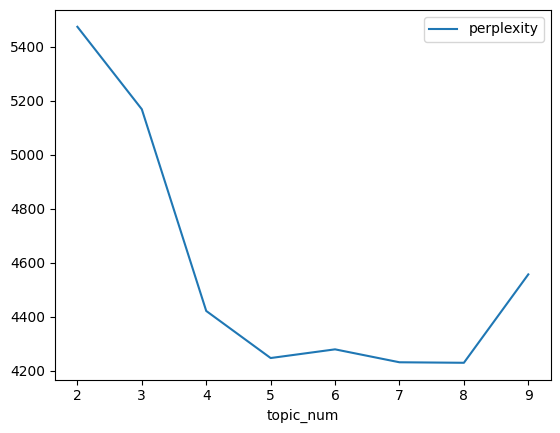

In [36]:
result.plot.line(x='topic_num', y='perplexity')

perplexity越小越好，perplexity在5~8時表現不錯。

<Axes: xlabel='topic_num'>

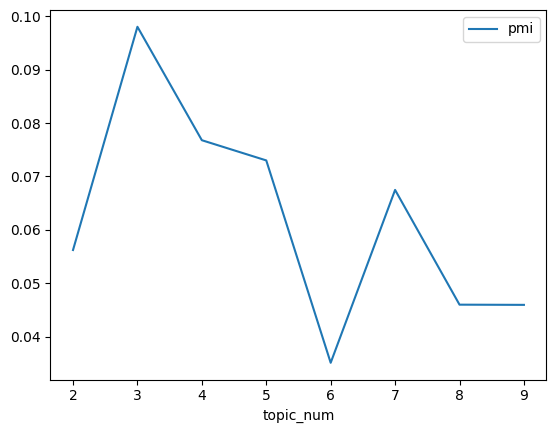

In [37]:
result.plot.line(x='topic_num', y='pmi')

pmi越大越好。就訓練結果來看，在主題數是 7 時表現最好。

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

**以下用主題數 7 、訓練次數 5 次來做 LDAvis**

In [38]:
best_model = LdaModel(
    corpus=corpus,
    num_topics=7,
    id2word=dictionary,
    random_state=1500,
    passes=5  # 訓練次數
)

2024-05-06 23:51:31,848 : INFO : using symmetric alpha at 0.14285714285714285
2024-05-06 23:51:31,849 : INFO : using symmetric eta at 0.14285714285714285
2024-05-06 23:51:31,852 : INFO : using serial LDA version on this node
2024-05-06 23:51:31,860 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 23:51:31,869 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-06 23:51:32,314 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-06 23:51:32,317 : INFO : topic #6 (0.143): 0.007*"醫師" + 0.004*"表示" + 0.004*"症狀" + 0.004*"台灣" + 0.004*"治療" + 0.004*"發現" + 0.003*"出現" + 0.003*"指出" + 0.003*"導致" + 0.003*"患者"
2024-05-06 23:51:32,317 : INFO : topic #4 (0.143): 0.008*"表示" + 0.005*"醫師" + 0.004*"出現" + 0.004*"症狀" + 0.004*"總統" + 0.004*"侯友宜" + 0.004*"問題" + 

In [39]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/opt/anaconda3/envs/sa_python38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.028711 -0.221168       1        1  38.276003
1      0.046396 -0.104488       2        1  18.428168
0      0.193308  0.132652       3        1  15.919003
5      0.019654 -0.120893       4        1  12.551065
6     -0.248623  0.095000       5        1  10.271946
3      0.178919  0.149388       6        1   2.470979
2     -0.218365  0.069508       7        1   2.082836, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  10765.000000  10765.000000  Default  30.0000  30.0000
1561  國民黨   9272.000000   9272.000000  Default  29.0000  29.0000
7953   大谷   2136.000000   2136.000000  Default  28.0000  28.0000
7476   柯文   7105.000000   7105.000000  Default  27.0000  27.0000
6044  侯友宜   6427.000000   6427.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
214    已經    143.021911   3100.047014   Topic7  -5.2520   0.7953
3298   網友    109.171925   1083.716635   Topic7  -5.5221   1.5762
4936   運動    102.222598    850.781476   Topic7  -5.5879   1.7524
179    表示    131.691688   6437.016324   Topic7  -5.3346  -0.0179
148    去年     94.407296    840.832030   Topic7  -5.6674   1.6847

[517 rows x 6 columns], token_table=       Topic      Freq Term
term                       
22182      5  0.994365   一壘
2038       1  0.357810   一天
2038       2  0.028341   一天
2038       3  0.178905   一天
2038       4  0.074396   一天
...      ...       ...  ...
16270      1  0.099111  高虹安
16270      2  0.002915  高虹安
16270      4  0.894918  高虹安
9925       1  0.997745   黨內
9925       4  0.001442   黨內

[1322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 6, 7, 4, 3])

可以看到(3,6)、(5,7)很相近，因此再試試看跑5個主題來查看結果

In [40]:
model_5 = LdaModel(
    corpus=corpus,
    num_topics=5,
    id2word=dictionary,
    random_state=6666,  #調參數
    passes=5  # 訓練次數
)

#經過了多次的random_state調參，我們發現random_state=6666時，分類表現最好。

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-06 23:51:48,110 : INFO : using symmetric alpha at 0.2
2024-05-06 23:51:48,112 : INFO : using symmetric eta at 0.2
2024-05-06 23:51:48,114 : INFO : using serial LDA version on this node
2024-05-06 23:51:48,119 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 23:51:48,121 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-06 23:51:48,555 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-06 23:51:48,558 : INFO : topic #0 (0.200): 0.005*"表示" + 0.005*"台灣" + 0.004*"醫師" + 0.003*"感染" + 0.003*"指出" + 0.003*"出現" + 0.003*"影響" + 0.003*"疾病" + 0.003*"症狀" + 0.003*"使用"
2024-05-06 23:51:48,559 : INFO : topic #1 (0.200): 0.008*"醫師" + 0.005*"症狀" + 0.005*"台灣" + 0.004*"出現" + 0.003*"表示" + 0.003*"治療" + 0.003*"問題" + 0.003*"民眾" + 0.003*"造成" + 0.003*"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.041476 -0.186742       1        1  40.515139
4     -0.038293 -0.116820       2        1  16.998453
2     -0.147882  0.177639       3        1  15.299817
0     -0.074495  0.063712       4        1  14.998398
1      0.302147  0.062212       5        1  12.188194, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  10571.000000  10571.000000  Default  30.0000  30.0000
7953   大谷   3734.000000   3734.000000  Default  29.0000  29.0000
1561  國民黨   9080.000000   9080.000000  Default  28.0000  28.0000
7476   柯文   6988.000000   6988.000000  Default  27.0000  27.0000
6044  侯友宜   6309.000000   6309.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
151    台灣   1288.567395   7149.269873   Topic5  -4.8205   0.3912
176    美國    735.436537   2138.408199   Topic5  -5.3813   1.0373
1352   最後    620.879936   2386.249194   Topic5  -5.5506   0.7584
179    表示    533.525117   6352.089052   Topic5  -5.7023  -0.3723
192    今年    482.497089   1363.730677   Topic5  -5.8028   1.0657

[401 rows x 6 columns], token_table=       Topic      Freq Term
term                       
442        1  0.731240   一定
442        2  0.039613   一定
442        3  0.136505   一定
442        4  0.041219   一定
442        5  0.051390   一定
...      ...       ...  ...
137        5  0.036622   體驗
16270      1  0.030977  高虹安
16270      2  0.963737  高虹安
16270      3  0.003442  高虹安
11945      3  0.995277  高血壓

[1037 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

可以看到各主題：1.選舉 2.其他 3.醫藥 4.經濟 5.體育

再試試看跑4個主題來查看有沒有比較好的結果

In [41]:
model_4 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 6666,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p1 = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
p1

2024-05-06 23:51:59,211 : INFO : using symmetric alpha at 0.25
2024-05-06 23:51:59,212 : INFO : using symmetric eta at 0.25
2024-05-06 23:51:59,214 : INFO : using serial LDA version on this node
2024-05-06 23:51:59,219 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 23:51:59,222 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-06 23:51:59,641 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-06 23:51:59,643 : INFO : topic #0 (0.250): 0.005*"表示" + 0.005*"台灣" + 0.004*"醫師" + 0.003*"感染" + 0.003*"指出" + 0.003*"出現" + 0.003*"影響" + 0.003*"症狀" + 0.003*"疾病" + 0.002*"增加"
2024-05-06 23:51:59,644 : INFO : topic #1 (0.250): 0.008*"醫師" + 0.005*"症狀" + 0.004*"台灣" + 0.004*"出現" + 0.004*"表示" + 0.003*"民眾" + 0.003*"問題" + 0.003*"治療" + 0.003*"發現" + 0.003

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.049392 -0.170926       1        1  47.310677
0     -0.076414 -0.065674       2        1  20.382631
2     -0.142455  0.187311       3        1  18.631035
1      0.268262  0.049289       4        1  13.675657, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  10423.000000  10423.000000  Default  30.0000  30.0000
7953   大谷   3697.000000   3697.000000  Default  29.0000  29.0000
1561  國民黨   8981.000000   8981.000000  Default  28.0000  28.0000
1483   立委   8060.000000   8060.000000  Default  27.0000  27.0000
6270  民進黨   7354.000000   7354.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
151    台灣   1321.708128   6528.214112   Topic4  -4.9103   0.3923
176    美國    705.526719   2147.224642   Topic4  -5.5380   0.8766
1352   最後    639.890714   2370.949158   Topic4  -5.6356   0.6798
179    表示    704.732355   6511.987211   Topic4  -5.5391  -0.2340
214    已經    523.807652   3222.678059   Topic4  -5.8358   0.1727

[305 rows x 6 columns], token_table=       Topic      Freq Term
term                       
15875      2  0.028209   一平
15875      3  0.001763   一平
15875      4  0.969677   一平
21122      3  0.004255   三振
21122      4  0.995615   三振
...      ...       ...  ...
9925       1  0.998357   黨內
9925       3  0.001492   黨內
1607       1  0.997455   黨團
1607       2  0.001476   黨團
1607       3  0.001476   黨團

[750 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

可以看到各主題：1.選舉 2.經濟 3.健康 4.體育

## 6. GuidedLDA

In [42]:
import guidedlda

In [43]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一下', '三越', '中小學', '人心', '休閒', '住宅', '住戶', '保護區', '俯瞰', '健康')

In [44]:
word2id = dictionary.token2id

把政治中的選舉、議會相關分開

In [45]:
seed_topic_list = [
    ["投資","市場","股價","指數","美元"],
    ["醫師","症狀","糖尿病","治療","患者","健康","感染"],
    ["總統","國民黨","立委","民進黨","侯友宜","參選人"],
    ['亞運','選手','台灣','中華隊','比賽','金牌','決賽','成績','對手'],
    ["市府","議員","台北市","議會"], 
]

In [46]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [47]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [48]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-06 23:52:20,585 : INFO : n_documents: 8209
2024-05-06 23:52:20,590 : INFO : vocab_size: 22897
2024-05-06 23:52:20,590 : INFO : n_words: 1311245
2024-05-06 23:52:20,591 : INFO : n_topics: 5
2024-05-06 23:52:20,591 : INFO : n_iter: 100
2024-05-06 23:52:27,027 : INFO : <0> log likelihood: -13928265
2024-05-06 23:52:27,802 : INFO : <20> log likelihood: -11222806
2024-05-06 23:52:28,541 : INFO : <40> log likelihood: -11168682
2024-05-06 23:52:29,275 : INFO : <60> log likelihood: -11153730
2024-05-06 23:52:30,007 : INFO : <80> log likelihood: -11146556
2024-05-06 23:52:30,738 : INFO : <99> log likelihood: -11141675


In [49]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/opt/anaconda3/envs/sa_python38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Topic 0: 台灣 表示 美國 公司 中國 今年 萬元 指出 日本 政府
Topic 1: 醫師 症狀 發現 治療 出現 導致 表示 健康 患者 造成
Topic 2: 總統 國民黨 柯文 侯友宜 民進黨 立委 參選人 民眾 賴清德 候選人
Topic 3: 亞運 選手 台灣 中華隊 比賽 大谷 金牌 拿下 大運 球員
Topic 4: 表示 立委 市長 議員 民進黨 萬安 台北 相關 已經 徐巧


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.075080  0.163708       1        1  35.966596
4     -0.086157  0.183305       2        1  21.402083
0     -0.007602 -0.010616       3        1  14.817262
1     -0.239673 -0.181376       4        1  14.543495
3      0.258351 -0.155021       5        1  13.270564, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  11038.000000  11038.000000  Default  30.0000  30.0000
1561  國民黨   9497.000000   9497.000000  Default  29.0000  29.0000
7476   柯文   7363.000000   7363.000000  Default  28.0000  28.0000
6044  侯友宜   7277.000000   7277.000000  Default  27.0000  27.0000
7395  參選人   4378.000000   4378.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
1706   追蹤    451.464208    636.316947   Topic5  -5.9544   1.6764
3119   朋友    509.394174   1207.878827   Topic5  -5.8336   1.1562
192    今年    531.367610   1538.390356   Topic5  -5.7914   0.9566
142    中國    551.343460   2183.919776   Topic5  -5.7545   0.6431
179    表示    492.414701   6374.477126   Topic5  -5.8675  -0.5411

[349 rows x 6 columns], token_table=       Topic      Freq Term
term                       
442        1  0.646635   一定
442        2  0.107860   一定
442        3  0.064190   一定
442        4  0.125223   一定
442        5  0.056298   一定
...      ...       ...  ...
10177      2  0.016775   飲食
10177      4  0.984116   飲食
5924       1  1.000547  馬英九
16270      2  1.000759  高虹安
13728      2  1.000563   黨工

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

分成的五類與我們的seed_topic區分結果吻合（分成：經濟、健康、選舉、體育、議會）
這說明我們的seed_topic是有效的

再另外嘗試把體育中的籃球、棒球分開

In [50]:
seed_topic_list = [
    ["職籃", "籃球", "林書豪", "籃板", "助攻","季後賽","西區","雲豹"],
    ['中職', '兄弟', '樂天', "全壘打", "三振", '勝投', '大谷'],
    ["投資","市場","股價","指數","美元"],
    ["總統","國民黨","立委","民進黨","侯友宜","參選人"],
    ["市府","議員","台北市","議會"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [51]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-06 23:52:37,669 : INFO : n_documents: 8209
2024-05-06 23:52:37,670 : INFO : vocab_size: 22897
2024-05-06 23:52:37,671 : INFO : n_words: 1311245
2024-05-06 23:52:37,671 : INFO : n_topics: 5
2024-05-06 23:52:37,671 : INFO : n_iter: 100
2024-05-06 23:52:44,132 : INFO : <0> log likelihood: -13964475
2024-05-06 23:52:44,935 : INFO : <20> log likelihood: -11362079
2024-05-06 23:52:45,697 : INFO : <40> log likelihood: -11238169
2024-05-06 23:52:46,453 : INFO : <60> log likelihood: -11198242
2024-05-06 23:52:47,199 : INFO : <80> log likelihood: -11178607
2024-05-06 23:52:47,940 : INFO : <99> log likelihood: -11165779


In [52]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/opt/anaconda3/envs/sa_python38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Topic 0: 亞運 選手 中華隊 台灣 金牌 比賽 拿下 大運 杭州 最後
Topic 1: 大谷 表示 球員 網友 聯盟 日本 球迷 台灣 球隊 翔平
Topic 2: 台灣 表示 公司 萬元 中國 政府 美國 相關 指出 今年
Topic 3: 總統 國民黨 立委 民進黨 柯文 侯友宜 參選人 市長 民眾 賴清德
Topic 4: 醫師 發現 症狀 表示 出現 治療 導致 造成 健康 指出


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.024610  0.162660       1        1  45.826905
2     -0.109570  0.057724       2        1  19.052728
4     -0.226347 -0.195255       3        1  16.818916
1      0.079008  0.132305       4        1   9.835703
0      0.281519 -0.157434       5        1   8.465749, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  11038.000000  11038.000000  Default  30.0000  30.0000
1561  國民黨   9497.000000   9497.000000  Default  29.0000  29.0000
1483   立委   7811.000000   7811.000000  Default  28.0000  28.0000
6270  民進黨   7586.000000   7586.000000  Default  27.0000  27.0000
7476   柯文   7363.000000   7363.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
142    中國    473.207475   2183.821595   Topic5  -5.4578   0.9398
2925   男子    388.351385    798.011859   Topic5  -5.6554   1.7489
940    這次    395.339534   1316.670198   Topic5  -5.6376   1.2660
303    參加    375.373395    970.956648   Topic5  -5.6894   1.5188
1706   追蹤    364.392018    636.123659   Topic5  -5.7191   1.9120

[344 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1223       1  0.032416   一名
1223       2  0.010373   一名
1223       3  0.698885   一名
1223       4  0.259327   一名
15875      4  1.001069   一平
...      ...       ...  ...
272        3  0.993584   食物
272        4  0.005449   食物
10177      3  0.995211   飲食
10177      5  0.005591   飲食
21117      5  1.001438   體操

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])

體育確實分成了兩類，但是結果並不是以籃球、棒球所區分的
在這裡我們可以看到，GuidedLDA的結果並不是完全符合我們的預期

## 7. 主題分佈的應用，搭配其他文章資訊

In [53]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [54]:
topics_doc[100]

[(0, 0.4008115), (4, 0.592218)]

In [55]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.8148635 , 0.        , 0.        , 0.03732764, 0.14549012],
       [0.85501432, 0.        , 0.0123745 , 0.12702617, 0.        ],
       [0.89636731, 0.        , 0.03952003, 0.        , 0.06074163],
       ...,
       [0.07984087, 0.42180204, 0.        , 0.        , 0.49536392],
       [0.        , 0.99221051, 0.        , 0.        , 0.        ],
       [0.        , 0.81117588, 0.        , 0.        , 0.18022822]])

In [56]:
data['topic_label'] = m_theta.argmax(axis=1) + 1

In [57]:
data['topic_label'].value_counts()

4    3461
5    1295
2    1261
1    1193
3     999
Name: topic_label, dtype: int64

In [58]:
data.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,台南安平區除有歷史悠久的古蹟外開發近年的五期重劃區兼具生活機能及慢活悠閒步調是許多在地人心之...,https://news.ebc.net.tw/news/article/365123,財經,2023-05-05 14:00:00,"[台南, 安平, 區除, 歷史悠久, 古蹟, 開發, 近年, 五期, 重劃, 兼具, 生活,...",1
1,美國股神巴菲特今天盛讚台積電是了不起的公司但承認旗下波克夏海瑟威公司把資金配置在日本比配置在...,https://news.ebc.net.tw/news/article/365550,財經,2023-05-08 11:30:00,"[美國, 股神, 巴菲特, 今天, 盛讚, 台積, 電是, 了不起, 公司, 承認, 旗下,...",1
2,為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食物和生活用品今年總捐贈金額更達萬元是歷年...,https://news.ebc.net.tw/news/article/365827,財經,2023-05-10 17:31:00,"[幫助, 弱勢, 族群, 期交所, 攜手, 金融機構, 辦理, 食物, 銀行, 捐贈, 食物...",1
3,今天舉辦年度開發者大會發表款硬體新產品包括中階手機折疊手機及平板電腦並宣布旗下生成式人工智慧...,https://news.ebc.net.tw/news/article/365885,財經,2023-05-11 10:01:00,"[今天, 舉辦, 年度, 開發者, 大會, 發表, 硬體, 產品, 包括, 中階, 手機, ...",1
4,日前一輛新車因停車格塌陷而爆出新竹天坑事件以及快速道路死亡車禍引起汽車險業者高度關注雖然兩起...,https://news.ebc.net.tw/news/article/366027,財經,2023-05-12 09:21:00,"[日前, 一輛, 新車, 停車, 塌陷, 爆出, 新竹, 天坑, 事件, 快速道路, 死亡,...",1


In [59]:
data['artDate'] = pd.to_datetime(data['artDate'])


依照年和月來查看各主題隨時間的分布狀況

In [60]:
data.groupby([data['artDate'].dt.year,data['artDate'].dt.month])['topic_label'].value_counts(normalize=True)

artDate  artDate  topic_label
2023     5        4              0.477193
                  3              0.175439
                  2              0.152632
                  5              0.114035
                  1              0.080702
         6        4              0.333333
                  5              0.304527
                  3              0.150206
                  2              0.115226
                  1              0.096708
         7        4              0.379004
                  2              0.281139
                  5              0.129893
                  1              0.104982
                  3              0.104982
         8        2              0.350254
                  4              0.304569
                  5              0.149746
                  3              0.116751
                  1              0.078680
         9        2              0.370508
                  4              0.262701
                  5              0.187113
    

In [61]:
date_topic = data.groupby([data['artDate'].dt.year,data['artDate'].dt.month])['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label             1         2         3         4         5
artDate artDate                                                  
2023    5        0.080702  0.152632  0.175439  0.477193  0.114035
        6        0.096708  0.115226  0.150206  0.333333  0.304527
        7        0.104982  0.281139  0.104982  0.379004  0.129893
        8        0.078680  0.350254  0.116751  0.304569  0.149746
        9        0.112763  0.370508  0.066914  0.262701  0.187113

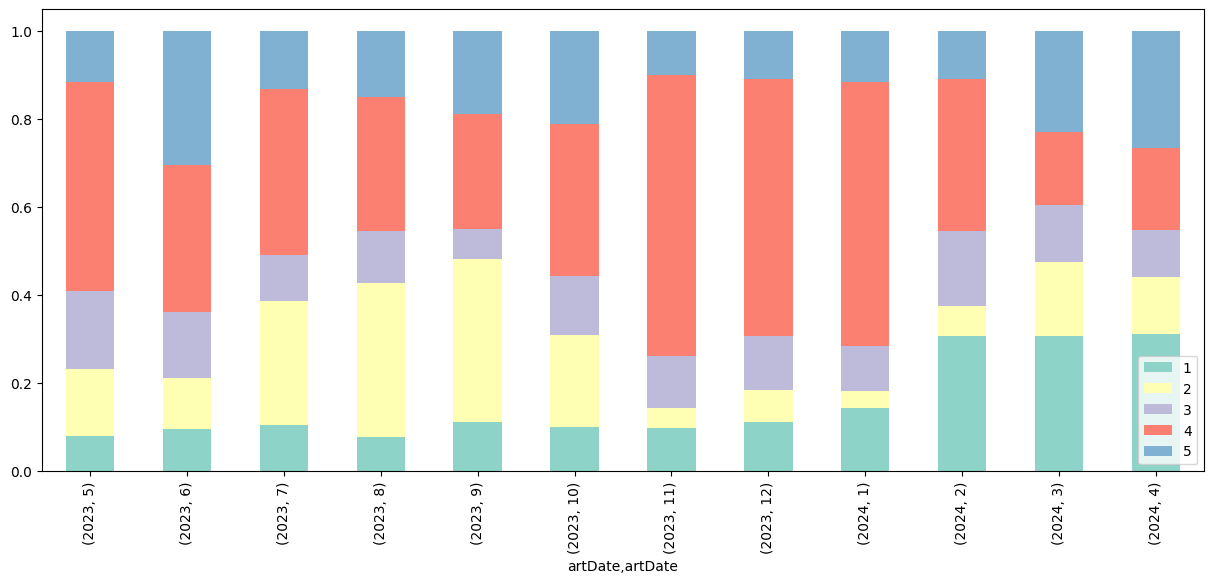

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

圖中的各主題分別是 : 
1. 經濟
2. 其他
3. 體育
4. 選舉
5. 醫藥

可以發現，在總統大選前（2024年1月），選舉相關新聞數量逐漸增加，當選舉完後（2024年2月），數量逐漸減少。

結論：  
- 我們嘗試了使用4、5、7個類別來查看分群狀況。其中，我們認為模型分群效果最佳的是落在4或5個主題之間。  
- 當嘗試7或4個主題時，結果發現模型會將經濟相關的內容與其他主題混合在一起，導致很難區分出來。  
- 因此最終我們選擇了使用 **5 個主題**的模型作為 best model。
- 在嘗試變更超參數時，我們發現到num_topics會顯著影響到模型的分群效果，因此我們認為這是一個重要的超參數。
- 此外，在調整過程中random_state也會影響到模型的分群效果，因此使用該方法分析主題時，會受到隨機性的影響。

# Week11

week11的部分我們分成兩個雲端檔案呈現：

- https://drive.google.com/drive/folders/1aUWfMN1WZpd6eCT64COa32RbR0uSHJQe
- https://drive.google.com/drive/folders/1zIhGiawLhWUPJjpSij6ZdI1HIN6mwyYv
